## pix2pix で PyTorch実装を学ぶ
- Reference
  - https://github.com/eriklindernoren/PyTorch-GAN
  - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/pix2pix
  

In [1]:
import os
import datetime
import numpy as np
import pandas as pd

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [4]:
# for model

import torch.nn as nn
import torch.nn.functional as F
import torch

In [5]:
# for datasets

import glob
import random
#import os
#import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

In [6]:
#torch.__version__

In [7]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '06_out')

In [8]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [9]:
cuda = True if torch.cuda.is_available() else False

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()

        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)
        ]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

In [13]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)
            ]

            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))

            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [47]:
class pix2pix:
    def __init__(self, data_loader, val_data_loader, img_height, img_width):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batche_i',
            'loss_D', 'loss_G', 'loss_pixel', 'loss_GAN',
            'elapsed_time'])

        self.data_loader = data_loader
        self.val_data_loader = val_data_loader

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.generator_name = 'generator_model'

        self.train_cnt = 0

        self.img_height = img_height
        self.img_width = img_width

        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

        self.adversarial_loss = torch.nn.MSELoss()

        # Loss functions
        self.criterion_GAN = torch.nn.MSELoss()
        self.criterion_pixelwise = torch.nn.L1Loss()

        # Loss weight of L1 pixel-wise loss between translated image and real image
        self.lambda_pixel = 100

        # Calculate output of image discriminator (PatchGAN)
        self.patch = (1, self.img_height // 2 ** 4, self.img_width // 2 ** 4)

        self.generator = GeneratorUNet()
        self.discriminator = Discriminator()

        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.criterion_GAN.cuda()
            self.criterion_pixelwise.cuda()

        # if opt.epoch != 0:
        #     # Load pretrained models
        #     generator.load_state_dict(torch.load('saved_models/%s/generator_%d.pth' % (opt.dataset_name, opt.epoch)))
        #     discriminator.load_state_dict(torch.load('saved_models/%s/discriminator_%d.pth' % (opt.dataset_name, opt.epoch)))
        # else:
        #     # Initialize weights
        #     generator.apply(weights_init_normal)
        #     discriminator.apply(weights_init_normal)
        self.generator.apply(weights_init_normal)
        self.discriminator.apply(weights_init_normal)

        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999

        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

    def train(self, n_epochs, sample_interval=-1):
        self.train_cnt += 1

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        step_cnt = 1

        for epoch in range(1, n_epochs+1):

            for i, batch in enumerate(self.data_loader, 1):
                # Model inputs
                real_A = Variable(batch['B'].type(self.Tensor))
                real_B = Variable(batch['A'].type(self.Tensor))

                # Adversarial ground truths
                valid = Variable(self.Tensor(np.ones((real_A.size(0), *self.patch))), requires_grad=False)
                fake  = Variable(self.Tensor(np.zeros((real_A.size(0), *self.patch))), requires_grad=False)

                # Train Generator
                self.optimizer_G.zero_grad()

                # GAN loss
                fake_B = self.generator(real_A)
                pred_fake = self.discriminator(fake_B, real_A)
                loss_GAN = self.criterion_GAN(pred_fake, valid)
                # Pixel-wise loss
                loss_pixel = self.criterion_pixelwise(fake_B, real_B)

                # Total loss
                loss_G = loss_GAN + self.lambda_pixel * loss_pixel

                loss_G.backward()

                self.optimizer_G.step()

                # Train Discriminator
                self.optimizer_D.zero_grad()

                # Real loss
                pred_real = self.discriminator(real_B, real_A)
                loss_real = self.criterion_GAN(pred_real, valid)

                # Fake loss
                pred_fake = self.discriminator(fake_B.detach(), real_A)
                loss_fake = self.criterion_GAN(pred_fake, fake)

                # Total loss
                loss_D = 0.5 * (loss_real + loss_fake)

                loss_D.backward()
                self.optimizer_D.step()

                # Log Progress
                batches_done = epoch * len(self.data_loader) + i
                elapsed_time = datetime.datetime.now() - start_time

                self.history = self.history.append({
                    'epoch': epoch,
                    'batch_i': i,
                    'loss_D': loss_D.item(),
                    'loss_G': loss_G.item(),
                    'loss_pixel': loss_pixel.item(),
                    'loss_GAN': loss_GAN.item(),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)


                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print(
                        '[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] %s'
                        % (
                            epoch,
                            n_epochs,
                            i,
                            len(self.data_loader),
                            loss_D.item(),
                            loss_G.item(),
                            loss_pixel.item(),
                            loss_GAN.item(),
                            elapsed_time
                        )
                    )
                    # sys.stdout.write(
                    #     '\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s'
                    #     % (
                    #         epoch,
                    #         opt.n_epochs,
                    #         i,
                    #         len(dataloader),
                    #         loss_D.item(),
                    #         loss_G.item(),
                    #         loss_pixel.item(),
                    #         loss_GAN.item(),
                    #         time_left,
                    #     )
                    # )

                    self.sample_images(epoch, i, 3)

                step_cnt += 1

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_images(self, epoch, batch_i, n_row=5):
        '''Saves a generated sample from the validation set'''
        imgs = next(iter(self.val_data_loader))

        real_A = Variable(imgs['B'].type(self.Tensor))
        real_B = Variable(imgs['A'].type(self.Tensor))
        fake_B = self.generator(real_A)
        img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)

        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(img_sample, file_name, nrow=n_row, normalize=True)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['loss_D', 'loss_G']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.generator, self.generator_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

In [48]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

        if mode == 'train':
            self.files.extend(sorted(glob.glob(os.path.join(root, 'test') + '/*.*')))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], 'RGB')
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], 'RGB')

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}

    def __len__(self):
        return len(self.files)

In [49]:
# Configure data loader
dataset_name = 'facades'
img_root_path = os.path.join(DATA_DIR_PATH, dataset_name)
img_height = 256
img_width = 256
batch_size = 1
n_cpu = 8

transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset(img_root_path, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

val_dataloader = DataLoader(
    ImageDataset(img_root_path, transforms_=transforms_, mode='val'),
    batch_size=3,
    shuffle=True,
    num_workers=1,
)

# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         MNIST_DATA_DIR_PATH,
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=batch_size,
#     shuffle=True,
# )

2020-09-11T19:33:15.145447 Start 1
[Epoch 1/1] [Batch 10/506] [D loss: 1.439098] [G loss: 35.211525, pixel: 0.338056, adv: 1.405908] 0:00:01.313426
[Epoch 1/1] [Batch 20/506] [D loss: 1.642132] [G loss: 41.377159, pixel: 0.391554, adv: 2.221751] 0:00:02.189625
[Epoch 1/1] [Batch 30/506] [D loss: 1.121629] [G loss: 41.675613, pixel: 0.406000, adv: 1.075608] 0:00:03.055748
[Epoch 1/1] [Batch 40/506] [D loss: 0.736553] [G loss: 45.646454, pixel: 0.448419, adv: 0.804583] 0:00:03.930532
[Epoch 1/1] [Batch 50/506] [D loss: 0.774553] [G loss: 42.714813, pixel: 0.418675, adv: 0.847292] 0:00:04.830982
[Epoch 1/1] [Batch 60/506] [D loss: 0.553015] [G loss: 45.855995, pixel: 0.452073, adv: 0.648710] 0:00:05.709468
[Epoch 1/1] [Batch 70/506] [D loss: 0.570275] [G loss: 35.736847, pixel: 0.350303, adv: 0.706529] 0:00:06.576881
[Epoch 1/1] [Batch 80/506] [D loss: 0.628032] [G loss: 36.222740, pixel: 0.355277, adv: 0.695085] 0:00:07.503962
[Epoch 1/1] [Batch 90/506] [D loss: 0.443188] [G loss: 29.920

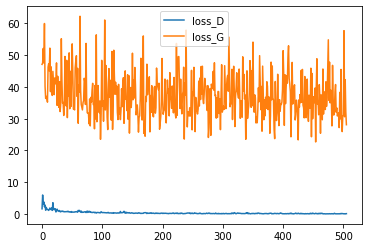

In [51]:
n_epochs = 1
sample_interval = 10

pix = pix2pix(dataloader, val_dataloader, img_height, img_width)
pix.train(n_epochs, sample_interval)

pix.plot_hisotry()

In [52]:
pix.save_models()

Model saved. generator_model
